# Lecture 6 - Data-Driven Analysis Using DynamicalSystems.jl

- Last week we saw how to model a dynamical system with a known dynamic rule using DynamicalSystems.jl. We also saw how to calculate various dynamical properties of such a system, for example, Lyapunov exponents.


- This week we will turn our attention to data-driven analysis using DynamicalSystems.jl, where we observe some system without necessarily knowing the dynamic rule in advance.


- More often than not, what we observe in real life isn't the entire phase space of the system, in which the dynamics unfold, but rather some projection of the state in phase space on to a lower dimensional space. That is why our discussion of data-driven algorithms will focus in particular on phase space reconstruction using coordinates embedding, as you saw in this part of the lecture.


## Contents

1. [Delay Coordinates Embedding](#embedding)
2. [Choosing the Optimal Delay Time](#time)
3. [Choosing the Optimal Embedding Dimension](#dimension)
4. [Putting It All Together](#together)
5. [Lyapunov Exponents](#lyapunov)
6. [Further Reading](#further-reading)

In [ ]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add("DynamicalSystems")
Pkg.add("NearestNeighbors")
Pkg.add("CairoMakie")

In [36]:
using DynamicalSystems, NearestNeighbors, CairoMakie

## 1. Delay Coordinates Embedding <a class="anchor" id="embedding"></a>

- Recall from the first part of the lecture that a scalar timeseries $s(t)$ can be embedded in a space of dimension $m$ via a time-delay embedding of the form $(s(t), s(t - \tau), s(t - 2\tau), \ldots, s(t - (m-1)\tau))$.


- To demonstrate delay coordinates embedding using DynamicalSystems.jl, we will "observe" the Lorenz system with a scalar measurement function $h : \mathbb{R}^3 \to \mathbb{R}$, such that our observation consists of a one-dimensional timeseries $s(t) = h(\mathbf{u}(t))$.


- For simplicity, we will take $s(t) = h(\mathbf{u}(t)) = x(t)$. If the three dimensions of the Lorenz system correspond roughly to the rate of convection and the horizontal and vertical temperature variations, respectively, then this is like saying that we observe only the rate of convection.

In [37]:
h(u) = u[:, 1]

h (generic function with 1 method)

In [38]:
# Generate synthetic data
ds = Systems.lorenz()
T = 100.0
Δt = 0.01
u = trajectory(ds, T; Ttr = 100.0, Δt)

3-dimensional Dataset{Float64} with 10001 points
 15.7333   11.4268    40.6889
 15.2211    9.3128    41.2033
 14.5583    7.24825   41.3359
 13.7675    5.30663   41.1248
 12.8755    3.54333   40.6231
 11.9106    1.99354   39.8913
 10.9012    0.673093  38.9903
  9.87326  -0.418587  37.9761
  8.84986  -1.29439   36.8966
  7.85012  -1.97535   35.7903
  6.88912  -2.48685   34.6858
  5.97801  -2.85572   33.6031
  5.12434  -3.10809   32.5554
  ⋮                   
  3.40547   4.63303   17.8369
  3.53713   4.94321   17.5315
  3.68682   5.27526   17.2522
  3.85498   5.63073   17.0011
  4.04217   6.01115   16.7805
  4.24901   6.418     16.5931
  4.47621   6.85257   16.442
  4.72453   7.31599   16.3309
  4.99476   7.80909   16.2638
  5.28765   8.33226   16.2452
  5.6039    8.8854    16.2803
  5.94412   9.46767   16.3747

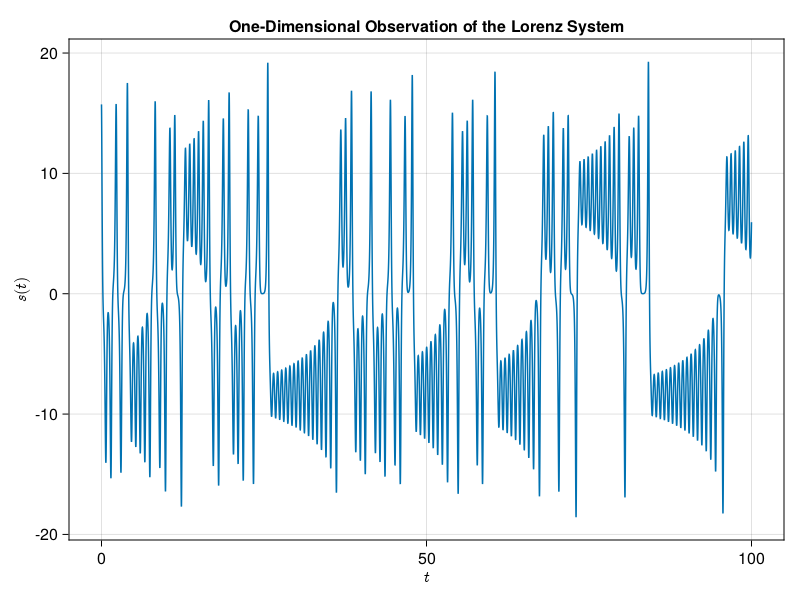

In [39]:
# "Measure" s(t) = h(u(t)) = x(t)
s = h(u)
fig = Figure()
ax = Axis(fig[1, 1], xlabel = L"t", ylabel = L"s(t)", title = "One-Dimensional Observation of the Lorenz System")
lines!(ax, 0:Δt:T, s)
fig

- To embed a one-dimensional timeseries $s(t)$ with embedding dimension $d$ and delay time $\tau \Delta t$, just do `embed(s, d, τ)` ([docs](https://juliadynamics.github.io/DynamicalSystems.jl/latest/embedding/reconstruction/#DelayEmbeddings.embed)).

In [40]:
d = 3
τ = 4
embed(s, d, τ)

3-dimensional Dataset{Float64} with 9993 points
 15.7333   12.8755   8.84986
 15.2211   11.9106   7.85012
 14.5583   10.9012   6.88912
 13.7675    9.87326  5.97801
 12.8755    8.84986  5.12434
 11.9106    7.85012  4.33254
 10.9012    6.88912  3.60446
  9.87326   5.97801  2.93989
  8.84986   5.12434  2.33701
  7.85012   4.33254  1.79287
  6.88912   3.60446  1.30369
  5.97801   2.93989  0.865168
  5.12434   2.33701  0.472741
  ⋮                  
  2.99161   3.05473  3.40547
  2.97892   3.11614  3.53713
  2.98565   3.19511  3.68682
  3.0111    3.29153  3.85498
  3.05473   3.40547  4.04217
  3.11614   3.53713  4.24901
  3.19511   3.68682  4.47621
  3.29153   3.85498  4.72453
  3.40547   4.04217  4.99476
  3.53713   4.24901  5.28765
  3.68682   4.47621  5.6039
  3.85498   4.72453  5.94412

- Let's plot the embedded attractor for a range of different delays $\tau$ and a fixed embedding dimension of 3.

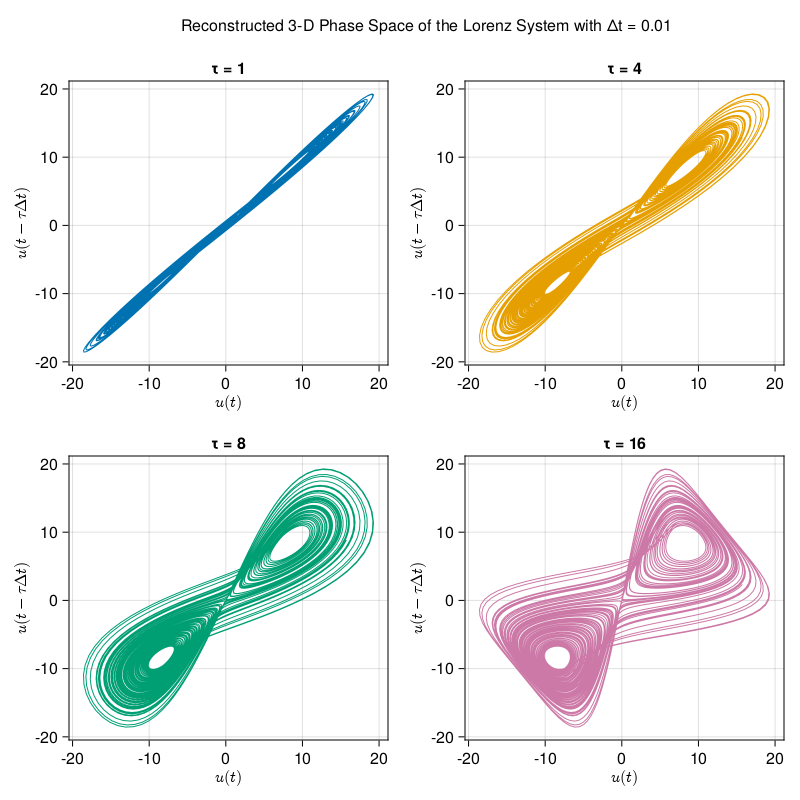

In [41]:
fig = Figure(resolution = (800, 800))
axes = [Axis(fig[1, 1]), Axis(fig[1, 2]), Axis(fig[2, 1]), Axis(fig[2, 2])]

for (i, τ) in enumerate([1, 4, 8, 16])
    data_embedded = embed(s, 3, τ)
    ax = axes[i]
    ax.title = "τ = $τ"
    ax.xlabel = L"u(t)"
    ax.ylabel = L"u(t-\tau \Delta t)"
    lines!(ax, data_embedded[:, 1], data_embedded[:, 2], color = Cycled(i), linewidth=1.0)
end

Label(fig[0, :], "Reconstructed 3-D Phase Space of the Lorenz System with Δt = $Δt")
fig

## 2. Choosing the Optimal Delay Time <a class="anchor" id="time"></a>

- Since no theorem exists guaranteeing an optimal choice of the delay time $\tau$, we must rely instead on a  **prescriptive approach**.


- As you saw in the first part of the lecture, two possibilities include using the autocorrelation and the self mutual information of the observed timeseries.


- Given the lack of an optimal method, it is especially important that we develop an intuitive understanding of the different approaches which are possible.


- Fortunately, while DynamicalSystems.jl provides useful high-level methods for estimating optimal time delays, it also exposes their low-level counterparts, permitting a more detailed, hands-on analysis.

### 2.1. Autocorrelation

- DynamicalSystems.jl uses the method `autocor` from the [StatsBase.jl](https://juliastats.org/StatsBase.jl/stable/) package for computing autocorrelations.


- It takes a one-dimensional timeseries as the first argument and an `AbstractVector` of lags as the second argument, returning a `Vector` of autocorrelations, one for each lag provided.

In [42]:
lags = 0:10
autocor(s, lags)

11-element Vector{Float64}:
 1.0
 0.9984701014153854
 0.9944818778839517
 0.9880896545043458
 0.9793789118131329
 0.9684638043215269
 0.9554839825868509
 0.9406008721119623
 0.9239935760369478
 0.9058545728292354
 0.8863853749634107

In [43]:
function plot_autocor(s, lags)
    fig = Figure()
    ax = Axis(
        fig[1, 1], 
        xlabel = L"\tau", 
        xminorticks = IntervalsBetween(5), 
        xminorticksvisible = true,
        xminorgridvisible = true,
        ylabel = "Autocorrelation", 
    )
    scatter!(ax, autocor(s, lags))
    return fig
end

plot_autocor (generic function with 1 method)

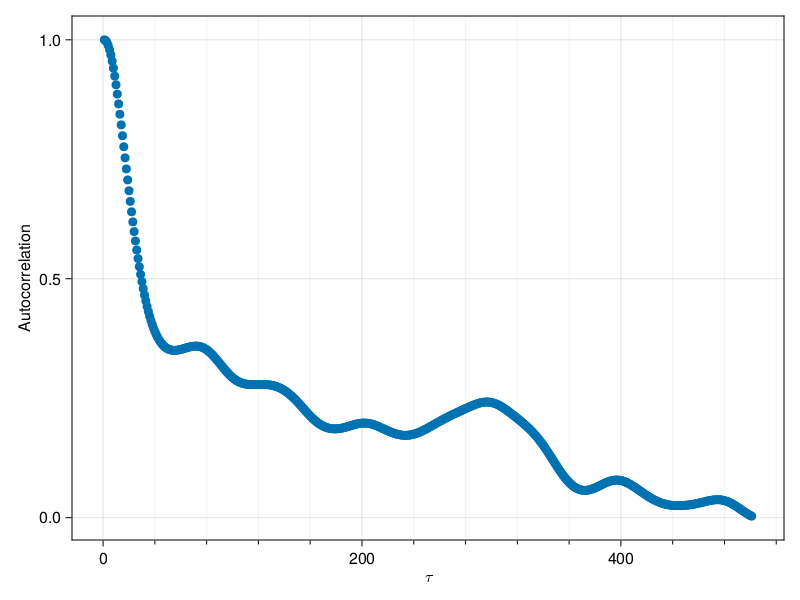

In [44]:
lags = 0:500
plot_autocor(s, lags)

- It looks like the first minimum occurs somewhere around $\tau = 50$, while the zero-crossing time is very long indeed, around $\tau = 500$.


- Sometimes, especially when embedding in higher dimensions, relying on the crossing time of the autocorrelation can lead to very long delays. Another alternative is to choose as a delay the time taken for the autocorrelation function to decay to $1/e$ of its initial value.


- DynamicalSystems.jl provides the method `exponential_decay_fit(x, y)` which performs a least squares fit of the form $y = \exp(\frac{x}{\tau})$ and returns $\tau$.

In [45]:
x = 10:40  # You must choose the lags such that the autocorrelation remains positive
y = autocor(s, x)
exponential_decay_fit(x, y)

33.4415100225862

- Based on the autocorrelation, we have three quite different estimates for the optimal delay.

### 2.2. Average Mutual Information

- As you learned earlier, a useful and often more robust alternative to autocorrelation is the average mutual information of the timeseries with itself at a given delay.


- DynamicalSystems.jl implements the method `selfmutualinfo(s, lags)`.

In [46]:
lags = 0:10
selfmutualinfo(s, lags)

11-element Vector{Float64}:
 4.6379641916961925
 3.5437817173344595
 3.024751698494582
 2.659633454718611
 2.379973997959472
 2.1560648008881693
 1.97091591300686
 1.8128559731008043
 1.679261391958082
 1.5687783171710457
 1.468246029890417

In [47]:
function plot_selfmutualinfo(s, lags)
    fig = Figure()
    ax = Axis(
        fig[1, 1], 
        xlabel = L"\tau", 
        xminorticks = IntervalsBetween(5), 
        xminorticksvisible = true,
        xminorgridvisible = true,  
        ylabel = "Self Mutual Information", 
    )
    scatter!(ax, selfmutualinfo(s, lags))
    return fig
end

plot_selfmutualinfo (generic function with 1 method)

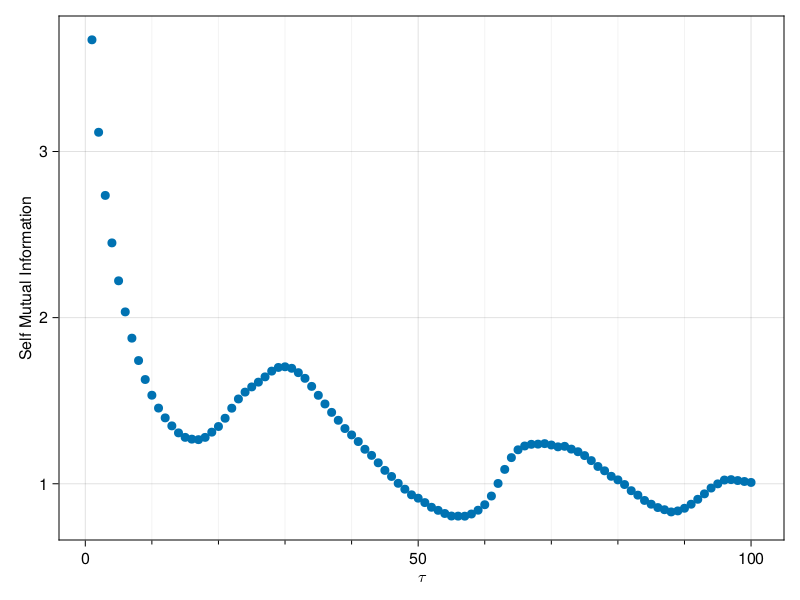

In [48]:
plot_selfmutualinfo(s, 1:100)

- It looks like the first minimum of the self mutual information occurs somewhere around $\tau = 17$.

In [49]:
Δt

0.01

### 2.3. The `estimate_delay` Method

- DynamicalSystems.jl wraps all of these options in the convenient `estimate_delay` method ([docs](https://juliadynamics.github.io/DynamicalSystems.jl/latest/embedding/traditional/#DelayEmbeddings.estimate_delay)).

In [50]:
estimate_delay(s, "ac_min")

54

In [51]:
estimate_delay(s, "ac_zero")

┌ Warning: Did not cross 0 value, returning last `τ`.
└ @ DelayEmbeddings /home/alistair/.julia/packages/DelayEmbeddings/41CFo/src/traditional_de/estimate_delay.jl:41


100

In [52]:
estimate_delay(s, "exp_decay")

76

In [53]:
estimate_delay(s, "mi_min")

17

- As you can see, there is quite a range of estimates for $\tau$, emphasising once again the importance of taking a heuristic approach,

## 3. Choosing the Optimal Embedding Dimension <a class="dimension" id="dimension"></a>

- Given an estimate for the time delay, we can proceed to find the embedding dimension using false nearest neighbours.


- In DynamicalSystems.jl, we can do this using the `delay_fnn` method ([docs](https://juliadynamics.github.io/DynamicalSystems.jl/latest/embedding/traditional/#DelayEmbeddings.delay_fnn)).

In [54]:
function plot_fnn(s, delay, dims)
    fnn = delay_fnn(s, delay, dims)
    
    fig = Figure()
    ax = Axis(
        fig[1, 1], 
        xlabel = "Embedding Dimension",
        #xminorticks = IntervalsBetween(5), 
        #xminorticksvisible = true,
        ylabel = "False Nearest Neighbours",
    )
    lines!(ax, dims, fnn)
    
    return fnn, fig
end

plot_fnn (generic function with 1 method)

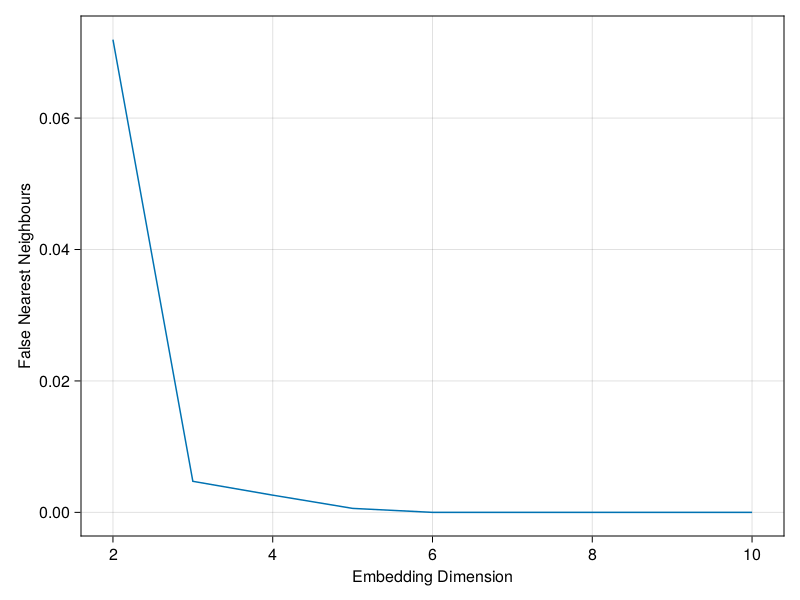

In [55]:
delay = 17
dims = 2:10
fnn, fig = plot_fnn(s, delay, dims)
fig

In [56]:
dims[findfirst(x -> x == 0, fnn)]

6

## 4. Putting It All Together <a class="anchor" id="together"></a>

- If you really do just want a quick embedding, you can fully automate the procedure outlined in the previous two sections using the method `optimal_traditional_de` ([docs](https://juliadynamics.github.io/DynamicalSystems.jl/latest/embedding/traditional/#DelayEmbeddings.optimal_traditional_de)), which returns the embedded timeseries $D$, the delay used $\tau$, and the statistic $E$ used to calculate the optimal embedding dimension.

In [57]:
D, τ, E = optimal_traditional_de(s)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional Dataset{Float64} with 9967 points, 17, [0.00022307998029236125, 0.3025005465380423, 0.9173965897689681, 0.9284301892523915, 0.9487094197969723, 0.967920831933992, 0.9831878885261732, 0.9957900715322417, 0.9922031769553573, 0.9857106416545169])

- Here, "traditional" means that the algorithm first estimates $\tau$, and then, with $\tau$ fixed, finds the optimal embedding dimension.


- DynamicalSystems.jl also contains modern "unified" algorithms, which are more sophisticated and jointly optimise the delay and the embedding dimension. See the [docs](https://juliadynamics.github.io/DynamicalSystems.jl/latest/embedding/unified/) for more details.


- Given the computational resources we have at our disposal, yet another option is to optimise the embedding with respect to the specific task at hand. For example, if we wish to make timeseries predictions, we could choose the embedding which leads to the most accurate predictions on some validation dataset. 

## 5. Lyapunov Exponents <a class="anchor" id="lyapunov"></a>

- As you know, the maximum Lyapunov exponent of a chaotic system measures the exponential divergence of infinitesimally close trajectories,

$$|\delta (t)| \approx e^{\lambda t}|\delta (0)|.$$


- Taking the log of both sides and letting $E(t) = \ln|\delta (t)|$,

$$E(t) \approx \lambda \times t + E(0).$$


- Now assume that the timeseries is sampled at equal intervals $\Delta t$ and therefore discretise time by letting $t = k \times Δt$, where $k = 0, 1, 2, \ldots$, such that

$$E(k) \approx \lambda \times k \times Δt + E(0).$$


- Given some dataset, we can now estimate the maximum Lyapunov exponent as the slope of the plot of $E(k)$ versus $k \times Δt$.


- We can estimate $E(k)$ from the data as follows:

    1. Define neighbourhoods within the data consisting of trajectories which are initially close together (e.g. using nearest neighbours).  

    2. Given those neighbourhoods, step the system forward $k$ steps and take the average of $E(k) = \ln|\delta (k)|$ over all neighbourhoods.  
    

- DynamicalSystems.jl makes this easy by providing the methods `lyapunov_from_data` and `linear_region`.

In [58]:
# Generate a longer timeseries than we used before
tr = trajectory(ds, 1000.0; Ttr = 100.0, Δt)
# s = sin.(tr[:, 1])
s = h(tr);

In [59]:
# Estimate the optimal embedding
D, τ, E = optimal_traditional_de(s)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional Dataset{Float64} with 99967 points, 17, [4.342833069252483e-5, 0.09751789740563081, 0.9120272622999638, 0.9393409196589221, 0.9579793504712669, 0.9633381369481636, 0.9826120382735596, 0.9870067984444081, 0.9927203115188912, 0.9890432244387202])

┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/alistair/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/alistair/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/alistair/.julia/packages/ChaosTools/PHPDF/src/dimensions/linear_regions.jl:143
┌ Warning: Found linear region spans less than a 3rd of the available x-axis and might imply inaccurate slope or insufficient data. Recommended: plot `x` vs `y`.
└ @ ChaosTools /home/alistair/.julia/packages/ChaosT

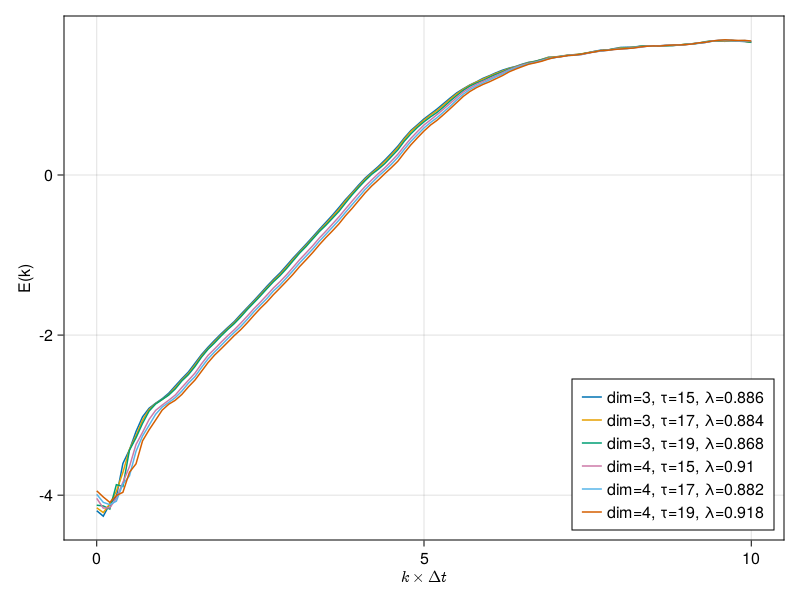

In [60]:
k_values = 0:10:1000  # Integer timesteps k * Δt

fig = Figure(figsize = (500, 500))
ax = Axis(fig[1, 1], xlabel = L"k \times Δt", ylabel="E(k)")

for dim in [3, 4], τ in [15, 17, 19]  # Try different embedding dimensions and time delays
    data_embedded = embed(s, dim, τ)
    E = lyapunov_from_data(data_embedded, k_values)  # Returns [E(k) for k ∈ k_values]
    λ = linear_region(k_values .* Δt, E)[2]          # Returns the slope of the linear region, i.e. the Lyapunov exponent
    lines!(
        ax, 
        k_values .* Δt, 
        E, 
        label = "dim=$(dim), τ=$(τ), λ=$(round(λ, digits = 3))",
    )
end

axislegend(ax, position = :rb)
fig

- How do these estimates compare to the true Lyapunov exponent?

In [61]:
lyapunov(ds, 10000.0, Ttr = 100)

0.9056697568289074

- Our estimates for the Lyapunov exponent aren't bad at all, considering we started with a one-dimensional observation of the system and relied on a fully automated identification of the optimal embedding.

## 6. Further Reading <a class="anchor" id="further-reading"></a>

1. [DynamicalSystems.jl documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/embedding/reconstruction/)
2. [Nonlinear Time Series Analysis (Kantz & Schreiber 2003)](https://www.cambridge.org/core/books/nonlinear-time-series-analysis/519783E4E8A2C3DCD4641E42765309C7)
3. [Analysis of Observed Chaotic Data (Abarbanel 1996)](https://link.springer.com/book/10.1007/978-1-4612-0763-4)